In [4]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask

import collections.abc
collections.Iterable = collections.abc.Iterable
import xscale

In [1]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:35437' processes=16 threads=128, memory=251.08 GiB>

# Read ROMS output data

In [5]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
figure_dir = '/meddy/lwang/figures/model_validation/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
mask=grd.mask_rho

In [7]:
grd

<xarray.Dataset> Size: 210MB
Dimensions:     (eta_rho: 1296, xi_rho: 1502, eta_v: 1295, xi_u: 1501)
Dimensions without coordinates: eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/21)
    angle       (eta_rho, xi_rho) float64 16MB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 16MB ...
    flip_xy     float64 8B ...
    h           (eta_rho, xi_rho) float64 16MB ...
    hraw        (eta_rho, xi_rho) float64 16MB ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 16MB ...
    river_flux  (eta_rho, xi_rho) float32 8MB ...
Attributes:
    Title:     ROMS grid produced by Easy Grid
    Settings:  nx=1500 ny=1294 size_x=3000 size_y=2500 cent_lat=55 tapering=0...
    Date:      16-Apr-2024
    history:   Thu Nov 21 11:12:03 2024: ncks -x -v river_flux SWC2km_grd.nc ...
    NCO:       netCDF Operators version 4.9.2-alpha05 (Homepage = http://nco....

In [35]:
filenames = sorted(glob.glob(data_path+'SWC2km_his.*.nc')) 
print('Number of files processed: %d' %len(filenames))

#for name in glob.glob(data_path+'z_SWC2km_his.145*.nc'):
#    print(name)

Number of files processed: 1460


In [36]:
#filenames = sorted(glob.glob(data_path+'z_SWC2km_his.*.nc')) 
#print('Number of files processed: %d' %len(filenames))

In [37]:
ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
ds

<xarray.Dataset> Size: 48TB
Dimensions:     (time: 8760, auxil: 6, eta_rho: 1296, xi_rho: 1502, xi_u: 1501,
                 eta_v: 1295, s_rho: 100, s_w: 101)
Dimensions without coordinates: time, auxil, eta_rho, xi_rho, xi_u, eta_v,
                                s_rho, s_w
Data variables: (12/13)
    ocean_time  (time) float64 70kB dask.array<chunksize=(6,), meta=np.ndarray>
    time_step   (time, auxil) int32 210kB dask.array<chunksize=(6, 6), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 260, 376), meta=np.ndarray>
    ubar        (time, eta_rho, xi_u) float32 68GB dask.array<chunksize=(1, 260, 376), meta=np.ndarray>
    vbar        (time, eta_v, xi_rho) float32 68GB dask.array<chunksize=(1, 259, 376), meta=np.ndarray>
    u           (time, s_rho, eta_rho, xi_u) float32 7TB dask.array<chunksize=(1, 100, 260, 376), meta=np.ndarray>
    ...          ...
    temp        (time, s_rho, eta_rho, xi_rho) float32 7TB dask.array<chunksize=(1, 100, 260, 376), meta=np.ndarray>
    salt        (time, s_rho, eta_rho, xi_rho) float32 7TB dask.array<chunksize=(1, 100, 260, 376), meta=np.ndarray>
    w           (time, s_rho, eta_rho, xi_rho) float32 7TB dask.array<chunksize=(1, 100, 260, 376), meta=np.ndarray>
    Akv         (time, s_w, eta_rho, xi_rho) float32 7TB dask.array<chunksize=(1, 101, 260, 376), meta=np.ndarray>
    Akt         (time, s_w, eta_rho, xi_rho) float32 7TB dask.array<chunksize=(1, 101, 260, 376), meta=np.ndarray>
    hbls        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 260, 376), meta=np.ndarray>
Attributes: (12/36)
    title:                 SWC , 2km resolution
    grid_file:             SWC2km_grd.000.nc
    init_file:             output/SWC2km_rst.145367.000.nc
    ntimes:                155520
    ndtfast:               28
    dt:                    100.0
    ...                    ...
    CPPS:                  <cppdefs.opt> EPAC2km SOLVE3D UV_ADV UV_COR ADV_IS...
    surf_forcing_strings:  
    bc_options:             OBC_EAST, OBC_NORTH, OBC_SOUTH, OBC_M3ORLANSKI, O...
    git_version:           7b470a484af0fea1f0b439bd1b92851ec842d0b7
    type:                  ROMS history file
    VertCoordType:         SM09

In [38]:
ds['pm']= (['eta_rho', 'xi_rho'],grd['pm'].data)
ds['pn']= (['eta_rho', 'xi_rho'],grd['pn'].data)
ds['f']= (['eta_rho', 'xi_rho'],grd['f'].data)

ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

In [8]:
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


 data size: 48145.4 GB


In [ ]:
'''
def u2rho_2d(var_u):

    [M,Lp]=var_u.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[1:M,:]=0.5*(var_u[0:Mm,:]+var_u[1:M,:])
    var_rho[0,:]=var_rho[1,:]
    var_rho[Mp-1,:]=var_rho[M-1,:]

    return var_rho
    
def v2rho_2d(var_v):

    [Mp,L]=var_v.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[:,1:L]=0.5*(var_v[:,0:Lm]+var_v[:,1:L])
    var_rho[:,0]=var_rho[:,1]
    var_rho[:,Lp-1]=var_rho[:,L-1]
    return var_rho

def u2rho_3d(var_u):

    [N,M,Lp]=var_u.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,1:M,:]=0.5*(var_u[:,0:Mm,:]+var_u[:,1:M,:])
    var_rho[:,0,:]=var_rho[:,1,:]
    var_rho[:,Mp-1,:]=var_rho[:,M-1,:]

    return var_rho

def v2rho_3d(var_v):

    [N,Mp,L]=var_v.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,:,1:L]=0.5*(var_v[:,:,0:Lm]+var_v[:,:,1:L,])
    var_rho[:,:,0]=var_rho[:,:,1]
    var_rho[:,:,Lp-1]=var_rho[:,:,L-1]
    
    return var_rho
    
    
ds_u = ds[['u']].isel(depth=0)
ds_v = ds[['v']].isel(depth=0)
print(ds_u)
print(ds_v)


ds_u = ds_u.chunk({'time': 1, 'eta_rho': 1296, 'xi_u': 1501})
ds_v = ds_v.chunk({'time': 1, 'eta_v': 1295, 'xi_rho': 1502})


%%time
u = v2rho_3d(ds_u.u)
v = u2rho_3d(ds_v.v)

%%time
u_bar = np.mean(u,axis=0)
v_bar = np.mean(v,axis=0)
'''

In [11]:
%%time
ds_u=xroms.to_grid(ds['u'].isel(depth=0), xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)


ds_v=xroms.to_grid(ds['v'].isel(depth=0), xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

CPU times: user 164 ms, sys: 9.98 ms, total: 174 ms
Wall time: 173 ms


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [12]:
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))


 data size: 68.2 GB

 data size: 68.2 GB


In [14]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [15]:
ds_u = ds_u.assign_coords(time=dtime) 
ds_v = ds_v.assign_coords(time=dtime) 

In [13]:
ds_u

<xarray.DataArray 'u' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 68GB
dask.array<transpose, shape=(8760, 1296, 1502), dtype=float32, chunksize=(6, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Attributes:
    long_name:  u-momentum component
    units:      meter second-1
    name:       u

In [15]:
%%time
ds_u.to_zarr(save_path+'surface_u.zarr',mode='w')
ds_v.to_zarr(save_path+'surface_v.zarr',mode='w')

CPU times: user 5min 31s, sys: 3min 17s, total: 8min 48s
Wall time: 2h 43min 32s


In [13]:
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_u = ds_u.chunk(chunks)
ds_v = ds_v.chunk(chunks)
print(ds_u)
print(ds_v)

<xarray.DataArray 'u' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 68GB
dask.array<rechunk-merge, shape=(8760, 1296, 1502), dtype=float32, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  u-momentum component
    units:      meter second-1
    name:       u
<xarray.DataArray 'v' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 68GB
dask.array<rechunk-merge, shape=(8760, 1296, 1502), dtype=float32, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  v-momentum component
    units:      meter second-1
    name: 

In [16]:
%%time
ds_u.to_zarr(save_path+'surface_u_rechunk.zarr',mode='w')
ds_v.to_zarr(save_path+'surface_v_rechunk.zarr',mode='w')

CPU times: user 11min 14s, sys: 6min 56s, total: 18min 10s
Wall time: 2h 39min 43s


# Read rechunked uv data

In [5]:
ds_u = xr.open_zarr(save_path + 'surface_u_rechunk.zarr')
print(ds_u)
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))


ds_v = xr.open_zarr(save_path + 'surface_v_rechunk.zarr')
print(ds_v)
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB
<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    v        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB


### daily averages

In [6]:
ds_u_daily = ds_u.resample(time='D').mean()
ds_v_daily = ds_v.resample(time='D').mean()

In [9]:
print('\n data size: %.1f GB' %(ds_u_daily.nbytes / 1e9))
print('\n data size: %.1f GB' %(ds_v_daily.nbytes / 1e9))


 data size: 2.8 GB

 data size: 2.8 GB


In [7]:
%%time
ds_u_daily.to_zarr(save_path+'surface_u_daily.zarr',mode='w')
ds_v_daily.to_zarr(save_path+'surface_v_daily.zarr',mode='w')

CPU times: user 28.7 s, sys: 8.29 s, total: 36.9 s
Wall time: 1min 39s


In [8]:
%%time
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_u_daily = ds_u_daily.chunk(chunks)
ds_v_daily = ds_v_daily.chunk(chunks)
ds_u_daily.to_zarr(save_path+'surface_u_daily_rechunk.zarr',mode='w')
ds_v_daily.to_zarr(save_path+'surface_v_daily_rechunk.zarr',mode='w')

CPU times: user 36.3 s, sys: 12.8 s, total: 49.1 s
Wall time: 1min 40s


In [22]:
ds_u = xr.open_zarr(save_path + 'surface_u_daily_rechunk.zarr')
print(ds_u)
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))


ds_v = xr.open_zarr(save_path + 'surface_v_daily_rechunk.zarr')
print(ds_v)
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))

<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 2.8 GB
<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    v        (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 2.8 GB


In [11]:
%%time
ke = (ds_u.u**2 + ds_v.v**2)/2
ke_masked = ke.where(mask > 0)

CPU times: user 4.12 ms, sys: 4.01 ms, total: 8.13 ms
Wall time: 8.1 ms


In [12]:
ds_ke=ke_masked.rename('ke').to_dataset()
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_ke = ds_ke.chunk(chunks)
ds_ke

<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    ke       (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [13]:
%%time
ds_ke.to_zarr(save_path+'surface_ke_daily_rechunk.zarr',mode='w')

CPU times: user 453 ms, sys: 95.8 ms, total: 549 ms
Wall time: 988 ms


In [23]:
%%time
u_bar = ds_u.mean(dim='time')
v_bar = ds_v.mean(dim='time')

CPU times: user 5.14 ms, sys: 1.04 ms, total: 6.18 ms
Wall time: 6.17 ms


In [24]:
%%time
mke = (u_bar.u**2 + v_bar.v**2)/2

CPU times: user 2.51 ms, sys: 2.12 ms, total: 4.63 ms
Wall time: 4.62 ms


In [25]:
mke.load()

<xarray.DataArray (eta_rho: 1296, xi_rho: 1502)> Size: 8MB
array([[0.        , 0.        , 0.        , ..., 0.17413095, 0.17671728,
        0.17830682],
       [0.        , 0.        , 0.        , ..., 0.17643085, 0.17921588,
        0.18074545],
       [0.        , 0.        , 0.        , ..., 0.17921922, 0.1817178 ,
        0.18289566],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0068148 , 0.00737117,
        0.00639989],
       [0.        , 0.        , 0.        , ..., 0.00606326, 0.00624717,
        0.00553407],
       [0.        , 0.        , 0.        , ..., 0.00556543, 0.00566274,
        0.00534523]], dtype=float32)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Attributes:
    long_name:  u-momentum component
    name:       u
    units:      meter second-1

In [17]:
uu = ds_u - u_bar
vv = ds_v - v_bar

In [18]:
%%time
eke = 0.5* (uu.u**2 + vv.v**2)
eke_masked = eke.where(mask > 0)

CPU times: user 3.32 ms, sys: 100 μs, total: 3.42 ms
Wall time: 3.44 ms


## save eke data

In [19]:
eke_masked.assign_attrs(long_name='eddy kinetic energy', name='eke', units='m^2/s^2', description='perturbation from annual mean')
ds_eke=eke_masked.rename('eke').to_dataset()

chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_eke = ds_eke.chunk(chunks)
ds_eke

<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    eke      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [20]:
%%time
ds_eke.to_zarr(save_path+'surface_eke_daily_rechunk.zarr',mode='w')

CPU times: user 1.8 s, sys: 462 ms, total: 2.26 s
Wall time: 7.21 s


# Read rechunked eke data and Plot

In [12]:
ds_eke = xr.open_zarr(save_path + 'surface_eke_daily_rechunk.zarr')
print(ds_eke)
print('\n data size: %.1f GB' %(ds_eke.nbytes / 1e9))

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 366, eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    eke      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 2.8 GB


In [13]:
annual_mean_eke = ds_eke.mean(dim='time')
annual_mean_eke

<xarray.Dataset> Size: 8MB
Dimensions:  (eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    eke      (eta_rho, xi_rho) float32 8MB dask.array<chunksize=(1296, 1502), meta=np.ndarray>

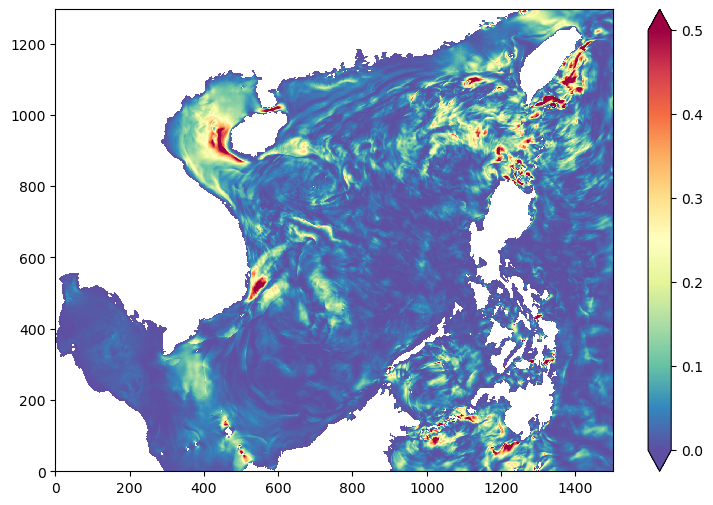

In [126]:
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
plot = plt.pcolormesh(eke[-1],vmin=0, vmax=0.5, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')

CPU times: user 2.71 s, sys: 314 ms, total: 3.02 s
Wall time: 3.97 s


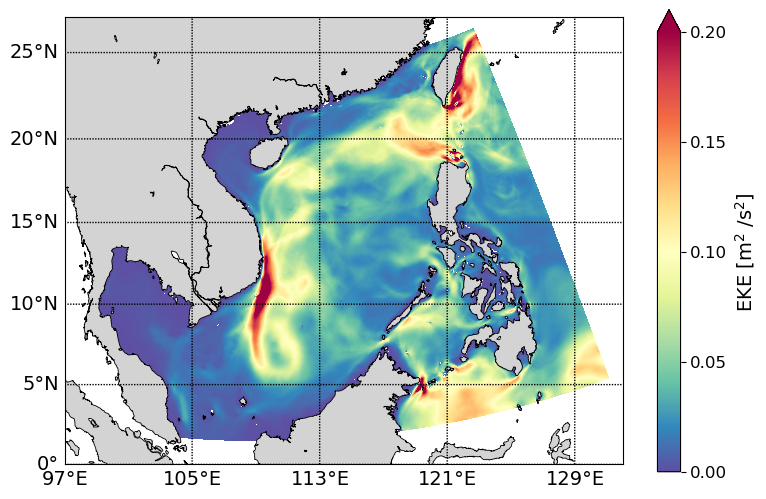

In [20]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_eke.eke,vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('EKE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'eke_daily_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.24 s, sys: 204 ms, total: 2.44 s
Wall time: 2.34 s


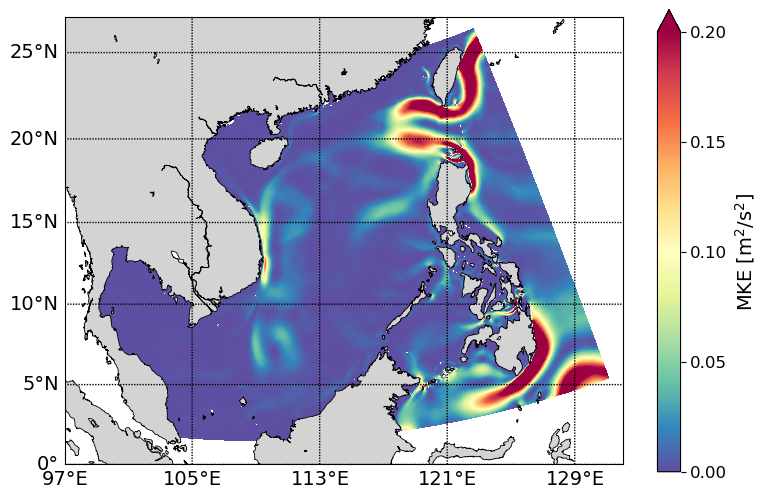

In [27]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, mke.where(mke > 0),vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('MKE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'mke_daily.png', bbox_inches='tight', dpi=500)

In [28]:
ds_ke = xr.open_zarr(save_path + 'surface_ke_daily_rechunk.zarr')
print(ds_ke)
print('\n data size: %.1f GB' %(ds_ke.nbytes / 1e9))
annual_mean_ke = ds_ke.mean(dim='time')
annual_mean_ke

<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    ke       (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 2.8 GB


<xarray.Dataset> Size: 8MB
Dimensions:  (eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    ke       (eta_rho, xi_rho) float32 8MB dask.array<chunksize=(1296, 1502), meta=np.ndarray>

CPU times: user 2.78 s, sys: 378 ms, total: 3.15 s
Wall time: 4.09 s


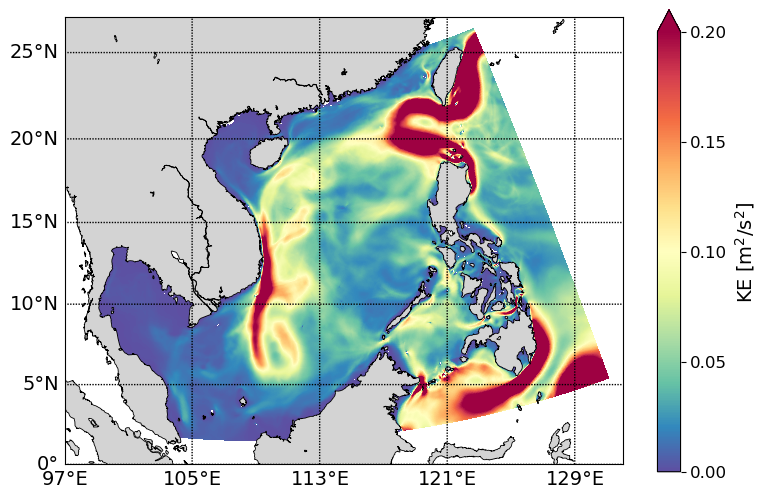

In [30]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_ke.ke,vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('KE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'ke_daily_annualmean.png', bbox_inches='tight', dpi=500)

In [10]:
%%time
plot_eke = annual_mean_eke.eke.to_numpy()
plot_lon = grd['lon_rho'].to_numpy()
plot_lat = grd['lat_rho'].to_numpy()

CPU times: user 11.9 s, sys: 2.25 s, total: 14.2 s
Wall time: 26.7 s


CPU times: user 12.3 s, sys: 2.17 s, total: 14.5 s
Wall time: 27 s


Text(0, 0.5, 'Kinetic energy $log_{10}$[m$^2$ s$^{-2}$]')

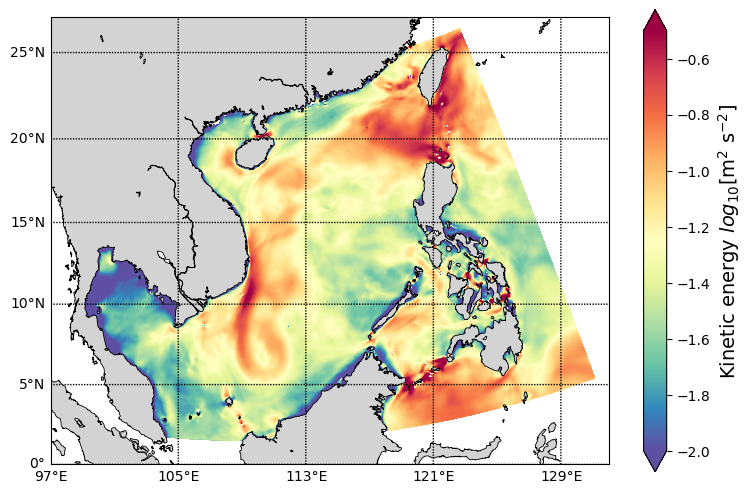

In [15]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, np.log10(annual_mean_eke.eke),vmin=-2, vmax=-0.5, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Kinetic energy ' + r'$log_{10}$' + '[m' + r'$^2$' + ' s' + r'$^{-2}$' + ']', fontsize=14)

# Geostrophic kinetic energy

## Sea surface height data

In [12]:
ds_zeta = ds.zeta
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))


 data size: 68.2 GB


In [13]:
ds_zeta = ds_zeta.where(mask > 0)

CPU times: user 884 ms, sys: 64.7 ms, total: 948 ms
Wall time: 934 ms


Text(0, 0.5, 'SSH [m]')

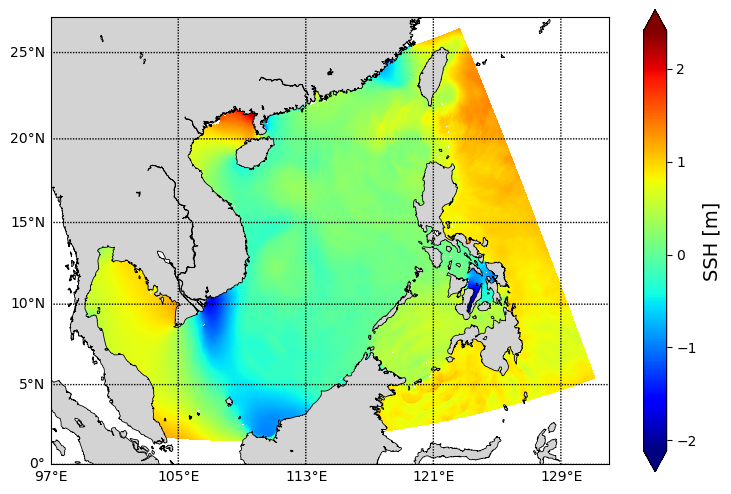

In [26]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, ds_zeta[1], cmap='jet')
cbar = fig.colorbar(plot,ax=ax, extend='both')
cbar.ax.set_ylabel('SSH [m]', fontsize=14)

In [14]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])
ds_zeta = ds_zeta.assign_coords(time=dtime) 

In [15]:
%%time
ds_zeta.to_zarr(save_path+'SSH.zarr',mode='w')

chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_zeta = ds_zeta.chunk(chunks)
print(ds_zeta)
ds_zeta.to_zarr(save_path+'SSH_rechunk.zarr',mode='w')
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 152.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'zeta' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 68GB
dask.array<rechunk-merge, shape=(8760, 1296, 1502), dtype=float32, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Attributes:
    long_name:  free-surface elevation
    units:      meter


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 120.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



 data size: 68.2 GB
CPU times: user 10min 22s, sys: 54.6 s, total: 11min 17s
Wall time: 13min 28s


In [16]:
ds_zeta = xr.open_zarr(save_path + 'SSH_rechunk.zarr')

### Temporal average

In [17]:
%%time
ds_zeta_daily = ds_zeta.resample(time='D').mean()
ds_zeta_daily.to_zarr(save_path+'SSH_daily.zarr',mode='w')
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_zeta_daily = ds_zeta_daily.chunk(chunks)
ds_zeta_daily.to_zarr(save_path+'SSH_daily_rechunk.zarr',mode='w')

CPU times: user 52 s, sys: 23.3 s, total: 1min 15s
Wall time: 2min 17s


In [21]:
%%time
ds_zeta_2day = ds_zeta.resample(time='2D').mean()
ds_zeta_2day.to_zarr(save_path+'SSH_2day.zarr',mode='w')
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_zeta_2day = ds_zeta_2day.chunk(chunks)
ds_zeta_2day.to_zarr(save_path+'SSH_2day_rechunk.zarr',mode='w')

CPU times: user 2.03 s, sys: 654 ms, total: 2.68 s
Wall time: 4.92 s


In [22]:
%%time
ds_zeta_4day = ds_zeta.resample(time='4D').mean()
ds_zeta_4day.to_zarr(save_path+'SSH_4day.zarr',mode='w')
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_zeta_4day = ds_zeta_4day.chunk(chunks)
ds_zeta_4day.to_zarr(save_path+'SSH_4day_rechunk.zarr',mode='w')

CPU times: user 1.64 s, sys: 504 ms, total: 2.14 s
Wall time: 4.92 s


### Add spatial filter

In [31]:
%%time
ds_zeta = xr.open_zarr(save_path + 'SSH_rechunk.zarr')
print(ds_zeta)
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))

grid_num = 15 #30km filter

wt_zeta = ds_zeta.window
wt_zeta.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'})
ds_zeta_filter = wt_zeta.convolve()
ds_zeta_filter  = ds_zeta_filter.where(mask > 0)

ds_zeta_filter.to_zarr(save_path+'SSH_filter.zarr',mode='w')

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 61.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-05-08 10:56:59,985 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('truediv-dcbce6d7b18d0e663e43c343486cd958', 0, 0, 0),)
2025-05-08 10:57:01,291 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('truediv-dcbce6d7b18d0e663e43c343486cd958', 0, 0, 0),)
2025-05-08 10:57:01,364 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('truediv-dcbce6d7b18d0e663e43c343486cd958', 0, 0, 0),)
2025-05-08 10:57:16,932 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('truediv-dcbce6d7b18d0

CPU times: user 1min 23s, sys: 7.83 s, total: 1min 31s
Wall time: 1min 35s


In [19]:
%%time
ds_zeta = xr.open_zarr(save_path + 'SSH_daily_rechunk.zarr')
print(ds_zeta)
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))

grid_num = 15 #30km filter

wt_zeta = ds_zeta.window
wt_zeta.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'})
ds_zeta_filter = wt_zeta.convolve()
ds_zeta_filter  = ds_zeta_filter.where(mask > 0)

ds_zeta_filter.to_zarr(save_path+'SSH_daily_filter.zarr',mode='w')

<xarray.Dataset> Size: 3GB
Dimensions:  (eta_rho: 1296, time: 366, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 3kB 2016-07-31 2016-08-01 ... 2017-07-31
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 2.8 GB
CPU times: user 3.15 s, sys: 360 ms, total: 3.51 s
Wall time: 5.11 s


In [23]:
%%time
ds_zeta = xr.open_zarr(save_path + 'SSH_2day_rechunk.zarr')
print(ds_zeta)
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))

grid_num = 15 #30km filter

wt_zeta = ds_zeta.window
wt_zeta.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'})
ds_zeta_filter = wt_zeta.convolve()
ds_zeta_filter  = ds_zeta_filter.where(mask > 0)

ds_zeta_filter.to_zarr(save_path+'SSH_2day_filter.zarr',mode='w')

<xarray.Dataset> Size: 1GB
Dimensions:  (eta_rho: 1296, time: 183, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 1kB 2016-07-31 2016-08-02 ... 2017-07-30
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 1.4 GB
CPU times: user 1.61 s, sys: 158 ms, total: 1.77 s
Wall time: 2.93 s


In [24]:
%%time
ds_zeta = xr.open_zarr(save_path + 'SSH_4day_rechunk.zarr')
print(ds_zeta)
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))

grid_num = 15 #30km filter

wt_zeta = ds_zeta.window
wt_zeta.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'})
ds_zeta_filter = wt_zeta.convolve()
ds_zeta_filter  = ds_zeta_filter.where(mask > 0)

ds_zeta_filter.to_zarr(save_path+'SSH_4day_filter.zarr',mode='w')

<xarray.Dataset> Size: 716MB
Dimensions:  (eta_rho: 1296, time: 92, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 736B 2016-07-31 2016-08-04 ... 2017-07-30
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 716MB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 0.7 GB
CPU times: user 809 ms, sys: 130 ms, total: 939 ms
Wall time: 1.85 s


### Read data and plot

In [25]:
ds_zeta = xr.open_zarr(save_path + 'SSH_rechunk.zarr')
#ds_zeta_daily = xr.open_zarr(save_path + 'SSH_daily_rechunk.zarr')
#ds_zeta_2day = xr.open_zarr(save_path + 'SSH_2day_rechunk.zarr')
#ds_zeta_4day = xr.open_zarr(save_path + 'SSH_4day_rechunk.zarr')

In [26]:
ds_zeta

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [27]:
ssh_annualmean = ds_zeta.mean(dim='time')
#ssh_spatialmean = ssh_annualmean.mean()
#ssh_anomaly = ssh_annualmean - ssh_spatialmean
ssh_spatialmean = ds_zeta.mean(dim=['eta_rho','xi_rho'])
ssha = ds_zeta - ssh_spatialmean
ssha_annualmean = ssha.mean(dim='time')

CPU times: user 15.2 s, sys: 3.71 s, total: 18.9 s
Wall time: 33.3 s


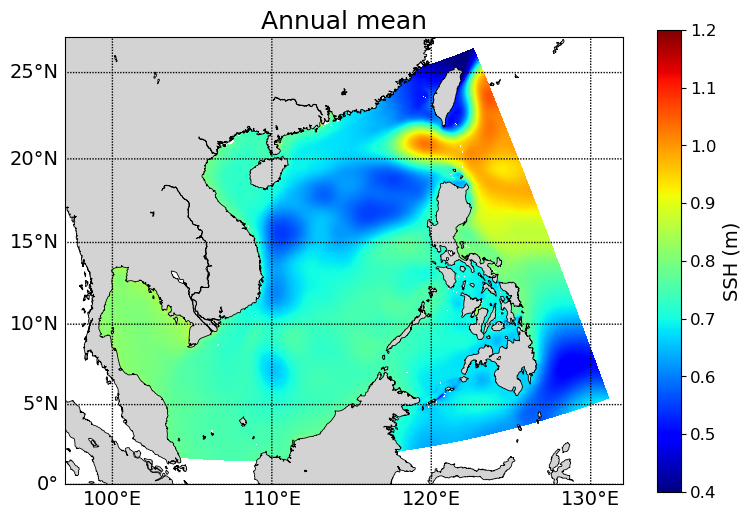

In [33]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, ssh_annualmean.zeta, vmin=0.4, vmax=1.2, cmap='jet')
cbar = fig.colorbar(plot,ax=ax)
cbar.ax.set_ylabel('SSH (m)', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('Annual mean', fontsize=18)
plt.savefig(figure_dir +'SSH_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 26.3 s, sys: 5.65 s, total: 31.9 s
Wall time: 43.9 s


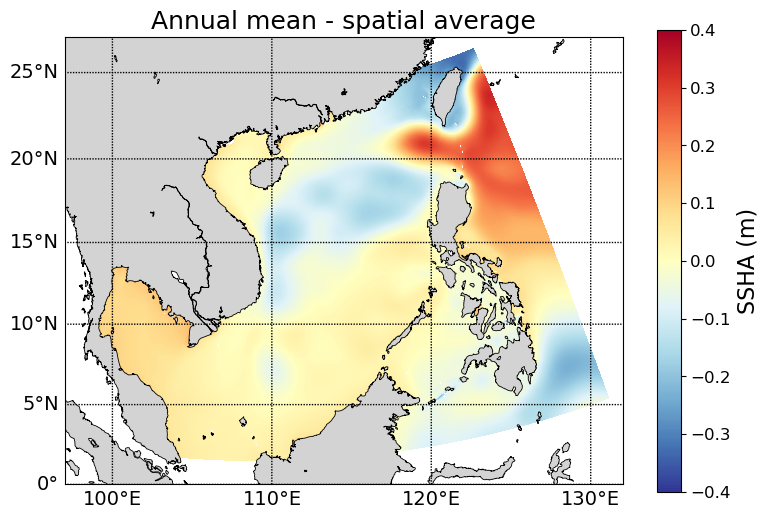

In [34]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, ssha_annualmean.zeta, vmin=-0.4, vmax=0.4, cmap='RdYlBu_r')
cbar = fig.colorbar(plot,ax=ax)
cbar.ax.set_ylabel('SSHA (m)', fontsize=16)
cbar.ax.tick_params(labelsize='large')

plt.title('Annual mean - spatial average', fontsize=18)
plt.savefig(figure_dir +'SSHA_annualmean.png', bbox_inches='tight', dpi=500)

In [17]:
ds_zeta = xr.open_zarr(save_path + 'SSH_filter.zarr')
#ssh_spatialmean = ssh_annualmean.mean()
#ssh_anomaly = ssh_annualmean - ssh_spatialmean
ssh_spatialmean = ds_zeta.mean(dim=['eta_rho','xi_rho'])
ssha = ds_zeta - ssh_spatialmean
ssha_annualmean = ssha.mean(dim='time')

CPU times: user 21 s, sys: 12.1 s, total: 33.1 s
Wall time: 1min 12s


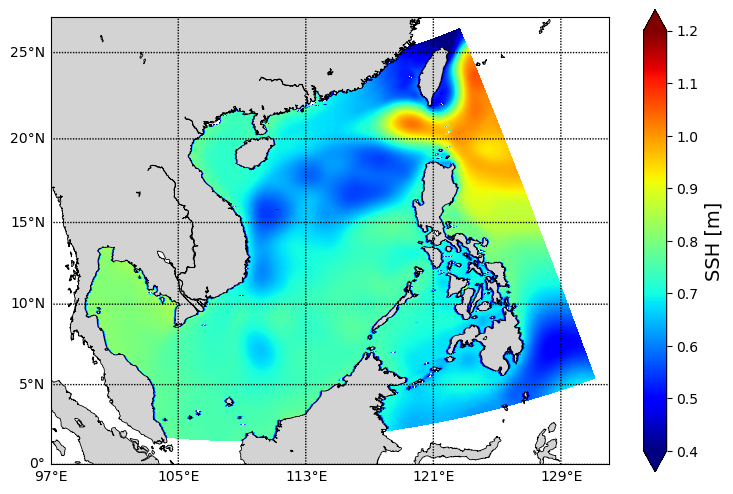

In [40]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, ssh_annualmean.zeta, vmin=0.4, vmax=1.2, cmap='jet')
cbar = fig.colorbar(plot,ax=ax, extend='both')
cbar.ax.set_ylabel('SSH [m]', fontsize=14)

plt.savefig(figure_dir +'SSH_30km_filter_annualmean.png', bbox_inches='tight')

CPU times: user 23.4 s, sys: 6.45 s, total: 29.8 s
Wall time: 59.2 s


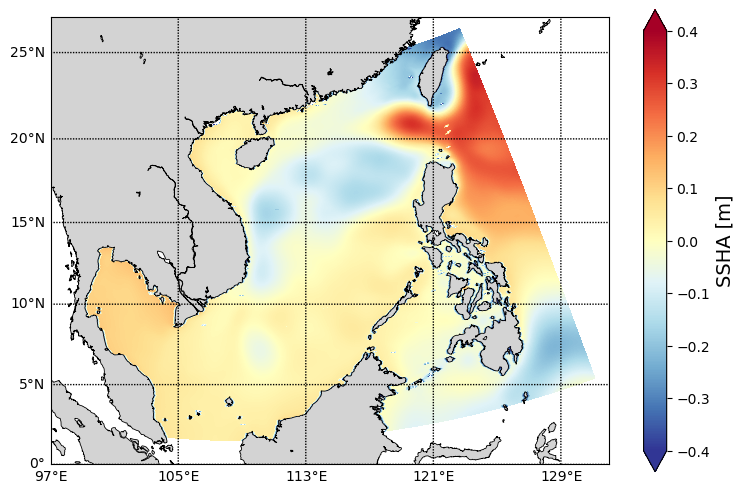

In [18]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, ssha_annualmean.zeta, vmin=-0.4, vmax=0.4, cmap='RdYlBu_r')
cbar = fig.colorbar(plot,ax=ax, extend='both')
cbar.ax.set_ylabel('SSHA [m]', fontsize=14)
plt.savefig(figure_dir +'SSHA_30km_filter_annualmean.png', bbox_inches='tight')

## Compute geostrophic velocity

In [39]:
ds_zeta = xr.open_zarr(save_path + 'SSH_4day_filter.zarr')
print(ds_zeta)
print('\n data size: %.1f GB' %(ds_zeta.nbytes / 1e9))
ds_zeta

<xarray.Dataset> Size: 716MB
Dimensions:  (eta_rho: 1296, time: 92, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 736B 2016-07-31 2016-08-04 ... 2017-07-30
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 716MB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 0.7 GB


<xarray.Dataset> Size: 716MB
Dimensions:  (eta_rho: 1296, time: 92, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 736B 2016-07-31 2016-08-04 ... 2017-07-30
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    zeta     (time, eta_rho, xi_rho) float32 716MB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [40]:
ug, vg = xroms.uv_geostrophic(ds_zeta.zeta, ds.f, xgrid)

ds_u=xroms.to_grid(ug, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)


ds_v=xroms.to_grid(vg, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [100]:
ds_u

<xarray.DataArray 'ug' (time: 92, eta_rho: 1296, xi_rho: 1502)> Size: 1GB
dask.array<transpose, shape=(92, 1296, 1502), dtype=float64, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  geostrophic u velocity
    units:      m/s
    name:       ug

In [101]:
%%time
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_u = ds_u.chunk(chunks)
ds_v = ds_v.chunk(chunks)
print(ds_u)
print(ds_v)

ds_u.to_zarr(save_path+'Ug_4day_filter.zarr',mode='w')
ds_v.to_zarr(save_path+'Vg_4day_filter.zarr',mode='w')

<xarray.DataArray 'ug' (time: 92, eta_rho: 1296, xi_rho: 1502)> Size: 1GB
dask.array<transpose, shape=(92, 1296, 1502), dtype=float64, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  geostrophic u velocity
    units:      m/s
    name:       ug
<xarray.DataArray 'vg' (time: 92, eta_rho: 1296, xi_rho: 1502)> Size: 1GB
dask.array<transpose, shape=(92, 1296, 1502), dtype=float64, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  geostrophic v velocity
    units:      m/s
    name:       vg


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 30.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 30.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.36 s, sys: 261 ms, total: 1.62 s
Wall time: 2.56 s


## Read data and plot

In [46]:
ds_u = xr.open_zarr(save_path + 'Ug_4day_filter.zarr')
print(ds_u)
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))


ds_v = xr.open_zarr(save_path + 'Vg_4day_filter.zarr')
print(ds_v)
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))



<xarray.Dataset> Size: 1GB
Dimensions:  (eta_rho: 1296, time: 92, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    ug       (time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 1.4 GB
<xarray.Dataset> Size: 1GB
Dimensions:  (eta_rho: 1296, time: 92, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    vg       (time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 1.4 GB


In [36]:
u_bar = ds_u.mean(dim='time')
v_bar = ds_v.mean(dim='time')

uu = ds_u - u_bar
vv = ds_v - v_bar

In [37]:
ke = 0.5* (ds_u.ug**2 + ds_v.vg**2)
ke = ke.where(mask > 0)
annual_mean_ke = ke.mean(dim='time')

In [38]:
mke = 0.5* (u_bar.ug**2 + v_bar.vg**2)
mke = mke.where(mask > 0)

In [39]:
eke = 0.5* (uu.ug**2 + vv.vg**2)
eke = eke.where(mask > 0)
ds_eke=eke.rename('eke').to_dataset()
ds_eke

<xarray.Dataset> Size: 6GB
Dimensions:  (eta_rho: 1296, xi_rho: 1502, time: 366)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    eke      (time, eta_rho, xi_rho) float64 6GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [40]:
print(ds_eke)
print('\n data size: %.1f GB' %(ds_eke.nbytes / 1e9))

<xarray.Dataset> Size: 6GB
Dimensions:  (eta_rho: 1296, xi_rho: 1502, time: 366)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    eke      (time, eta_rho, xi_rho) float64 6GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 5.7 GB


In [41]:
annual_mean_eke = ds_eke.mean(dim='time')
annual_mean_eke = annual_mean_eke.where(mask>0)

In [42]:
%%time
annual_mean_eke.load()

CPU times: user 3.87 s, sys: 2.3 s, total: 6.17 s
Wall time: 20.7 s


<xarray.Dataset> Size: 16MB
Dimensions:  (eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    eke      (eta_rho, xi_rho) float64 16MB nan nan nan ... 0.0004756 0.0003503

CPU times: user 7.33 s, sys: 858 ms, total: 8.19 s
Wall time: 10.3 s


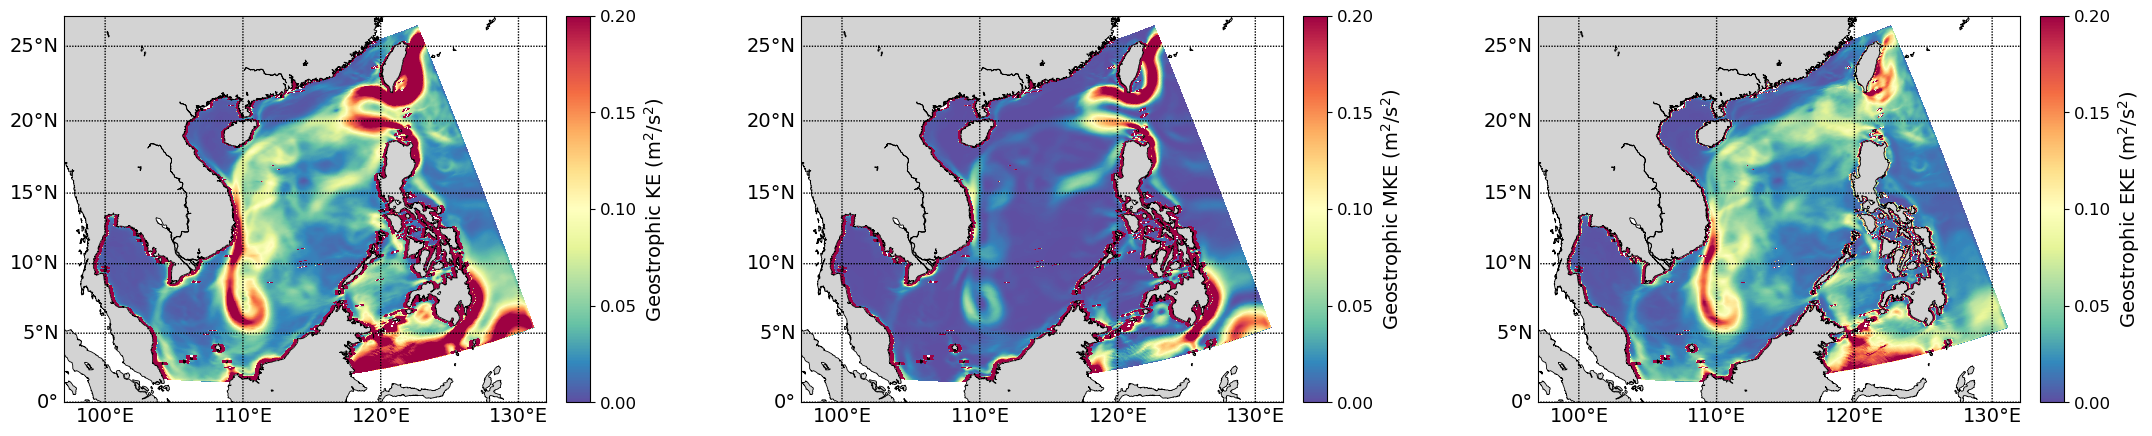

In [32]:
%%time
fig = plt.figure(figsize=(25, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)

ax = fig.add_subplot(131)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_ke, vmin=0, vmax=0.2, cmap='Spectral_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax,ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic KE (m' + r'$^2$' + '/s' + r'$^2$' + ')', fontsize=14)
cbar.ax.tick_params(labelsize='large')


ax = fig.add_subplot(132)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, mke, vmin=0, vmax=0.2, cmap='Spectral_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax,ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic MKE (m' + r'$^2$' + '/s' + r'$^2$' + ')', fontsize=14)
cbar.ax.tick_params(labelsize='large')


ax = fig.add_subplot(133)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_eke.eke, vmin=0, vmax=0.2, cmap='Spectral_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax,ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic EKE (m' + r'$^2$' + '/s' + r'$^2$' + ')', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'composite_geostrophic_ke_4day_30kmfilter_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 3.72 s, sys: 671 ms, total: 4.4 s
Wall time: 7.67 s


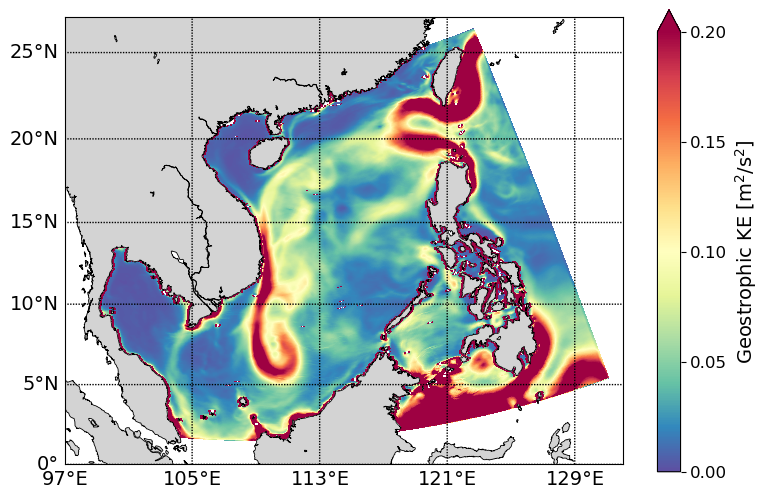

In [43]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_ke, vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic KE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')


plt.savefig(figure_dir +'geostrophic_ke_daily_30kmfilter_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 4.56 s, sys: 1.21 s, total: 5.77 s
Wall time: 11 s


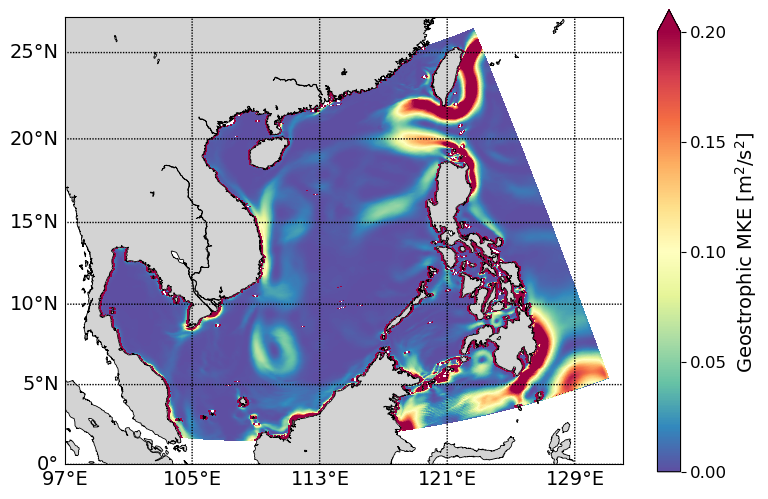

In [44]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, mke, vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic MKE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'geostrophic_mke_daily_30kmfilter_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.29 s, sys: 186 ms, total: 2.47 s
Wall time: 2.4 s


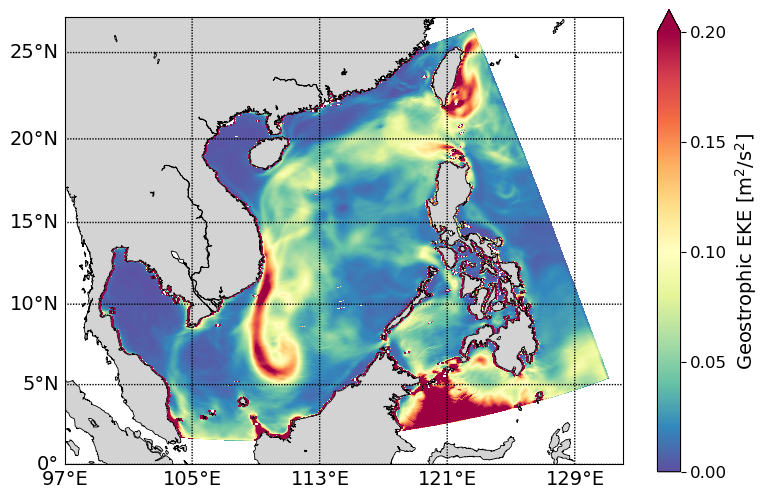

In [45]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_eke.eke, vmin=0, vmax=0.2, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='max',ticks=[0, 0.05, 0.1, 0.15, 0.2])
cbar.ax.set_ylabel('Geostrophic EKE [m' + r'$^2$' + '/s' + r'$^2$' + ']', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.savefig(figure_dir +'geostrophic_eke_daily_30kmfilter_annualmean.png', bbox_inches='tight', dpi=500)

In [66]:
%%time
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_eke = ds_eke.chunk(chunks)
ds_eke

#ds_eke.to_zarr(save_path+'geostrophic_eke_rechunk.zarr',mode='w')

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 1.74 ms


<xarray.Dataset> Size: 136GB
Dimensions:  (eta_rho: 1296, xi_rho: 1502, time: 8760)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    eke      (time, eta_rho, xi_rho) float64 136GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

# Try spatial and temporal filters

In [6]:
ds_u = xr.open_zarr(save_path + 'surface_u_rechunk.zarr')
print(ds_u)
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))


ds_v = xr.open_zarr(save_path + 'surface_v_rechunk.zarr')
print(ds_v)
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB
<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    v        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB


### spatial filter

In [32]:
grid_num = 15 #30km filter

In [33]:
wt_U = ds_u.window
wt_U.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'}, chunks = {'time':1, 'eta_rho':1,'xi_rho': 1502})
ds_U_filter = wt_U.convolve()

In [34]:
wt_V = ds_v.window
wt_V.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat_g':'hanning', 'lon':'hanning'}, chunks = {'time':1, 'eta_rho':1,'xi_rho': 1502})
ds_V_filter = wt_V.convolve()

### temporal filter

In [11]:
time_length = 24 #daily filter

In [13]:
wt_U = ds_u.window
wt_U.set(n={'time': time_length}, window='time':'hanning', chunks = {'time':1, 'eta_rho':1,'xi_rho': 1502})
ds_U_filter = wt_U.convolve()

ValueError: Unknown window type.

In [ ]:
wt_V = ds_V_filter.window
wt_V.set(n={'time': time_length}, window={'time':'hanning'}, chunks = {'time':1, 'eta_rho':1,'xi_rho': 1502})
ds_V_filter = wt_V.convolve()

In [24]:
%%time
u_bar = ds_U_filter.mean(dim='time')
v_bar = ds_V_filter.mean(dim='time')

uu = ds_u - u_bar
vv = ds_v - v_bar

eke = 0.5* (uu**2 + vv**2)
eke_masked = eke.where(eke > 0)

CPU times: user 18.9 ms, sys: 896 μs, total: 19.8 ms
Wall time: 19.4 ms


/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 20.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-04-28 06:09:48,584 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling (('truediv-d2c2951415d025f58551268dba531e36', 0, 4, 0), ('truediv-d2c2951415d025f58551268dba531e36', 0, 14, 0))
2025-04-28 06:09:49,791 - distributed.client - WARNING - Couldn't gather 20 keys, rescheduling (('truediv-d2c2951415d025f58551268dba531e36', 0, 4, 0), ('truediv-d2c2951415d025f58551268dba531e36', 0, 15, 0), ('truediv-d2c2951415d025f58551268dba531e36', 0, 17, 0), ('truediv-d2c2951415d025f58551268dba531e36', 0, 6, 0), ('truediv-d2c2951415d025f58551268dba531e36', 0,

CPU times: user 53.2 s, sys: 2.8 s, total: 56 s
Wall time: 56.5 s


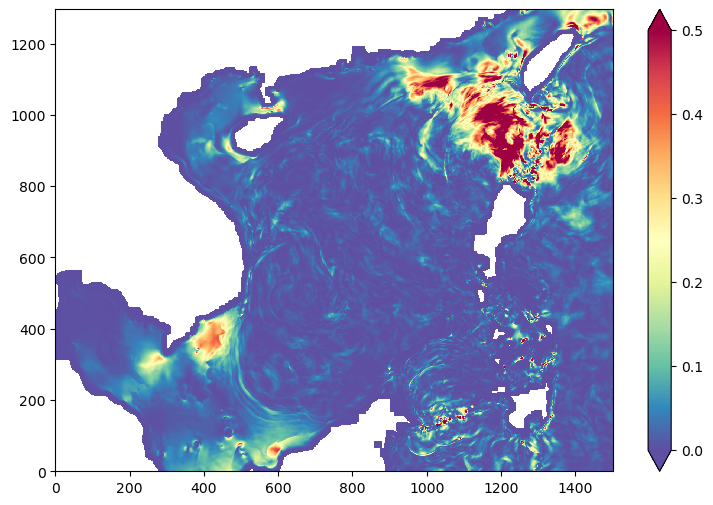

In [25]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
plot = plt.pcolormesh(eke_masked[-1],vmin=0, vmax=0.5, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')

In [17]:
%%time
u_bar = ds_u.mean(dim='time')
v_bar = ds_v.mean(dim='time')

uu = ds_u - u_bar
vv = ds_v - v_bar

eke = 0.5* (uu**2 + vv**2)
eke_masked = eke.where(eke > 0)

CPU times: user 7.24 ms, sys: 1.02 ms, total: 8.26 ms
Wall time: 8.16 ms


CPU times: user 165 ms, sys: 44.3 ms, total: 209 ms
Wall time: 680 ms


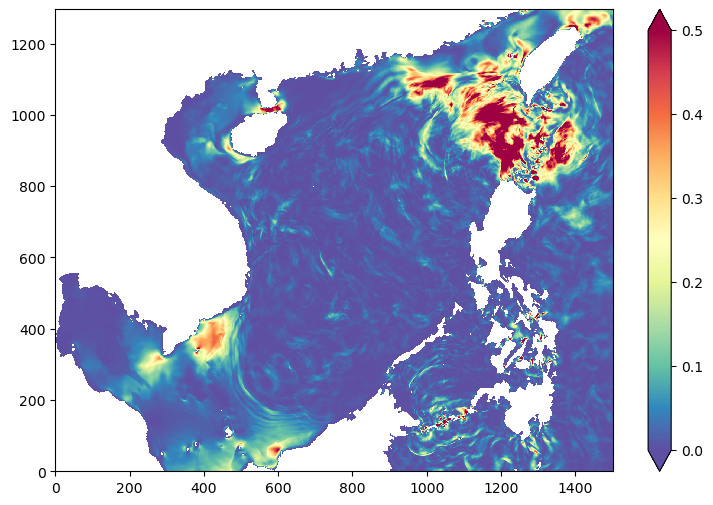

In [18]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
plot = plt.pcolormesh(eke_masked[-1],vmin=0, vmax=0.5, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')

In [ ]:
cluster.close()

In [16]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
ds = xr.open_dataset(data_path+'SWC2km_his.145373.nc')
ds['pm']= (['eta_rho', 'xi_rho'],grd['pm'].data)
ds['pn']= (['eta_rho', 'xi_rho'],grd['pn'].data)
ds['f']= (['eta_rho', 'xi_rho'],grd['f'].data)

ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)
ds

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

<xarray.Dataset> Size: 33GB
Dimensions:     (time: 6, auxil: 6, eta_rho: 1296, xi_rho: 1502, xi_u: 1501,
                 eta_v: 1295, s_rho: 100, s_w: 101)
Coordinates:
  * xi_rho      (xi_rho) int64 12kB 0 1 2 3 4 5 ... 1497 1498 1499 1500 1501
  * xi_u        (xi_u) int64 12kB 0 1 2 3 4 5 ... 1495 1496 1497 1498 1499 1500
  * eta_rho     (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1291 1292 1293 1294 1295
  * eta_v       (eta_v) int64 10kB 0 1 2 3 4 5 ... 1289 1290 1291 1292 1293 1294
Dimensions without coordinates: time, auxil, s_rho, s_w
Data variables: (12/28)
    ocean_time  (time) float64 48B ...
    time_step   (time, auxil) int32 144B ...
    zeta        (time, eta_rho, xi_rho) float32 47MB ...
    ubar        (time, eta_rho, xi_u) float32 47MB ...
    vbar        (time, eta_v, xi_rho) float32 47MB ...
    u           (time, s_rho, eta_rho, xi_u) float32 5GB ...
    ...          ...
    dy          (eta_rho, xi_rho) float64 16MB 2.518e+03 2.518e+03 ... 1.404e+03
    dy_u        (eta_rho, xi_u) float64 16MB 2.518e+03 2.518e+03 ... 1.404e+03
    dy_v        (eta_v, xi_rho) float64 16MB 2.517e+03 2.517e+03 ... 1.404e+03
    dy_psi      (eta_v, xi_u) float64 16MB 2.517e+03 2.517e+03 ... 1.404e+03
    dA          (eta_rho, xi_rho) float64 16MB 6.342e+06 6.342e+06 ... 1.972e+06
    rho0        int64 8B 1025
Attributes: (12/36)
    title:                 SWC , 2km resolution
    grid_file:             SWC2km_grd.000.nc
    init_file:             output/SWC2km_rst.145367.000.nc
    ntimes:                155520
    ndtfast:               28
    dt:                    100.0
    ...                    ...
    CPPS:                  <cppdefs.opt> EPAC2km SOLVE3D UV_ADV UV_COR ADV_IS...
    surf_forcing_strings:  
    bc_options:             OBC_EAST, OBC_NORTH, OBC_SOUTH, OBC_M3ORLANSKI, O...
    git_version:           7b470a484af0fea1f0b439bd1b92851ec842d0b7
    type:                  ROMS history file
    VertCoordType:         SM09

In [17]:
ds.xroms.xgrid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic, boundary=None):
  * center   eta_rho --> inner
  * inner    eta_v --> center

In [18]:
ug, vg = xroms.uv_geostrophic(ds.zeta, ds.f, xgrid)
#eke=xroms.EKE(ug, vg, xgrid)

In [19]:
ds_u=xroms.to_grid(ug, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)


ds_v=xroms.to_grid(vg, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)


In [20]:
speed = (ds_u**2+ds_v**2)**0.5

In [24]:
X.shape

(1296, 1502)

In [ ]:
X, Y = grd['lon_rho'], grd['lat_rho']
plt.quiver(X,Y,ds_u[0,:,:],ds_v[0,:,:])

In [8]:
u_bar = ds_u.mean(dim='time')
v_bar = ds_v.mean(dim='time')
uu = ds_u - u_bar
vv = ds_v - v_bar

In [9]:
eke = 0.5* (uu**2 + vv**2)
eke_masked = eke.where(eke > 0)
annual_mean_eke = eke_masked.mean(dim='time')

Text(0, 0.5, 'Kinetic energy [m$^2$ s$^{-2}$]')

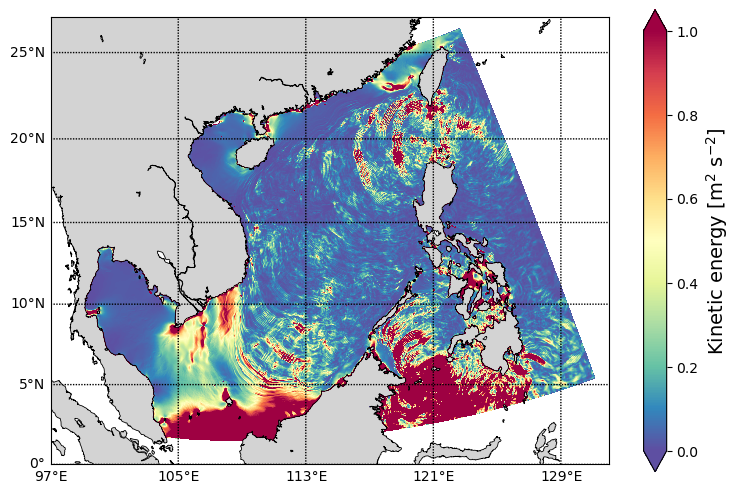

In [10]:
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_eke,vmin=0, vmax=1, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Kinetic energy [m' + r'$^2$' + ' s' + r'$^{-2}$' + ']', fontsize=14)

In [11]:
%%time
ds = xr.open_dataset(data_path+'z_SWC2km_his.145373.nc')

ds['pm']= (['eta_rho', 'xi_rho'],grd['pm'].data)
ds['pn']= (['eta_rho', 'xi_rho'],grd['pn'].data)
ds['f']= (['eta_rho', 'xi_rho'],grd['f'].data)

ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)

ds_u=xroms.to_grid(ds['u'].isel(depth=0), xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)


ds_v=xroms.to_grid(ds['v'].isel(depth=0), xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

u_bar = ds_u.mean(dim='time')
v_bar = ds_v.mean(dim='time')

uu = ds_u - u_bar
vv = ds_v - v_bar

eke = 0.5* (uu**2 + vv**2)
eke_masked = eke.where(eke > 0)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

CPU times: user 274 ms, sys: 152 ms, total: 426 ms
Wall time: 437 ms


In [12]:
annual_mean_eke = eke_masked.mean(dim='time')

Text(0, 0.5, 'Kinetic energy [m$^2$ s$^{-2}$]')

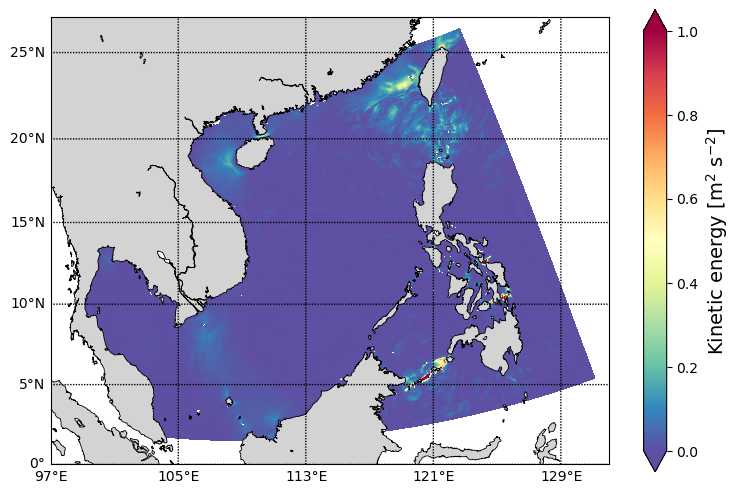

In [13]:
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1])


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_eke,vmin=0, vmax=1, cmap='Spectral_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Kinetic energy [m' + r'$^2$' + ' s' + r'$^{-2}$' + ']', fontsize=14)